[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab3-GenAI-LLM/notebooks/04-prompt-engineering.ipynb)

# Prompt Engineering for Helsefaglige Oppgaver

**ELMED219 / BMED365 - Lab 3**

---

## Læringsmål

Etter denne notebooken skal du kunne:
- Forstå forskjellen mellom *prompt engineering* og *context engineering*
- Mestre grunnleggende prompt-teknikker
- Anvende zero-shot og few-shot learning
- Implementere chain-of-thought for komplekse vurderinger
- Designe trygge prompts for medisinske oppgaver
- Komponere rik kontekst for kliniske AI-applikasjoner

## Innhold

1. [Grunnleggende prinsipper](#1-grunnleggende-prinsipper)
2. [Zero-shot vs. Few-shot](#2-zero-shot-vs-few-shot)
3. [Chain-of-Thought (CoT)](#3-chain-of-thought-cot)
4. [Strukturert output](#4-strukturert-output)
5. [Sikkerhet i medisinske prompts](#5-sikkerhet-i-medisinske-prompts)
6. [Praktiske eksempler](#6-praktiske-eksempler)
7. [GPT-5.2 Prompting Guide for medisin](#7-gpt-52-prompting-guide-for-medisin)
8. [Claude Opus 4.5 Prompting Guide for medisin](#8-claude-opus-45-prompting-guide-for-medisin)
9. [Gemini 3 Prompting Guide for medisin](#9-gemini-3-prompting-guide-for-medisin)

---

## 1. Grunnleggende prinsipper

God prompt engineering handler om å kommunisere tydelig med AI-modellen. Tenk på det som å gi instruksjoner til en svært kunnskapsrik, men bokstavelig assistent.

### Fra Prompt Engineering til Context Engineering

Mens **prompt engineering** fokuserer på å utforme gode spørsmål og instruksjoner, omfatter **context engineering** hele bildet av informasjon som modellen har tilgang til. Context engineering er kunsten å designe og administrere *hele kontekstvinduet* som en LLM bruker for å generere svar.

#### Hva er Context Engineering?

Context engineering handler om å strategisk komponere alle elementene som påvirker modellens respons:

| Komponent | Beskrivelse | Medisinsk eksempel |
|-----------|-------------|-------------------|
| **System prompt** | Grunnleggende instruksjoner og rolle | "Du er en klinisk beslutningsstøtte-assistent" |
| **Bruker-prompt** | Det spesifikke spørsmålet | "Vurder denne pasientens symptomer" |
| **Verktøy/funksjoner** | Tilgjengelige handlinger | Laboratoriesøk, legemiddeldatabase, ICD-10-oppslag |
| **Hentet kontekst (RAG)** | Dynamisk innhentet informasjon | Pasientjournal, retningslinjer, vitenskapelige artikler |
| **Samtalehistorikk** | Tidligere dialog | Forrige spørsmål og svar i konsultasjonen |
| **Strukturerte data** | Formattert informasjon | JSON med lab-verdier, vitale tegn |

#### Hvorfor er Context Engineering viktig i medisin?

I medisinske applikasjoner er kontekst *kritisk* fordi:

1. **Pasientsikkerhet**: Riktig kontekst kan forhindre farlige anbefalinger
2. **Personalisering**: Pasientspesifikk informasjon gir relevante svar
3. **Evidensbasering**: Tilgang til oppdaterte retningslinjer sikrer kvalitet
4. **Sporbarhet**: Strukturert kontekst muliggjør revisjon og kvalitetskontroll
5. **Regulatorisk compliance**: Dokumenterte kontekstkilder støtter krav til medisinsk programvare

#### Hvordan utvikle ferdigheter i Context Engineering?

| Ferdighetsnivå | Fokusområde | Praktisk øvelse |
|----------------|-------------|-----------------|
| **Nybegynner** | Prompt-formulering | Eksperimenter med rolle, format og eksempler |
| **Viderekommende** | Kontekstorganisering | Design strukturerte system prompts med seksjoner |
| **Avansert** | RAG og verktøy | Integrer eksterne kunnskapskilder og API-er |
| **Ekspert** | Orkestrering | Bygg multi-agent systemer med spesialiserte roller |

> 💡 **Tips**: Start med å tenke "Hvilken informasjon ville en erfaren kliniker trenge for å besvare dette spørsmålet?" – dette er kjernen i god context engineering.

### De fire grunnprinsippene for prompts

| Prinsipp | Beskrivelse | Eksempel |
|----------|-------------|----------|
| **Spesifisitet** | Vær konkret om hva du vil ha | "Skriv 3 punkter" vs. "Skriv litt" |
| **Kontekst** | Gi relevant bakgrunnsinformasjon | "Du er en allmennlege som..." |
| **Format** | Spesifiser ønsket output-format | "Svar i JSON-format" |
| **Eksempler** | Vis hva du forventer | Few-shot learning |

In [1]:
# Illustrasjon: Prompt Engineering vs. Context Engineering

# PROMPT ENGINEERING: Fokus på selve spørsmålet
enkel_prompt = "Hva er behandlingen for hjertesvikt?"

# CONTEXT ENGINEERING: Hele kontekstvinduet
kontekst_komponenter = {
    "system_prompt": """Du er en klinisk beslutningsstøtte-assistent ved et norsk sykehus.
    
VIKTIGE RETNINGSLINJER:
- Følg ESC Guidelines for Heart Failure 2023
- Henvis alltid til spesialist ved usikkerhet
- Aldri gi spesifikke doseringsanbefalinger uten farmasøytisk gjennomgang
- Dokumenter alltid kunnskapsgrunnlag med referanser""",
    
    "pasient_kontekst": {
        "alder": 72,
        "kjønn": "mann",
        "diagnoser": ["Hjertesvikt NYHA III", "Atrieflimmer", "Diabetes type 2"],
        "eGFR": 45,  # Nyrefunksjon - viktig for medikamentvalg
        "aktuelle_medisiner": ["Metformin 500mg x2", "Warfarin"],
        "allergier": ["Penicillin"]
    },
    
    "hentet_kontekst_RAG": [
        "ESC Guidelines 2023: SGLT2-hemmere anbefales uavhengig av EF...",
        "Interaksjonsdatabase: Warfarin + NSAID = økt blødningsrisiko..."
    ],
    
    "bruker_prompt": "Hvilke behandlingsendringer bør vurderes for denne pasienten?"
}

print("=" * 70)
print("ENKEL PROMPT (Prompt Engineering):")
print("=" * 70)
print(enkel_prompt)
print(f"\nKontekst tilgjengelig for modellen: {len(enkel_prompt)} tegn")

print("\n" + "=" * 70)
print("RIK KONTEKST (Context Engineering):")
print("=" * 70)
import json
print(json.dumps(kontekst_komponenter, indent=2, ensure_ascii=False))

total_kontekst = len(json.dumps(kontekst_komponenter))
print(f"\nKontekst tilgjengelig for modellen: {total_kontekst} tegn")
print(f"Forbedring: {total_kontekst / len(enkel_prompt):.0f}x mer kontekst")

ENKEL PROMPT (Prompt Engineering):
Hva er behandlingen for hjertesvikt?

Kontekst tilgjengelig for modellen: 36 tegn

RIK KONTEKST (Context Engineering):
{
  "system_prompt": "Du er en klinisk beslutningsstøtte-assistent ved et norsk sykehus.\n    \nVIKTIGE RETNINGSLINJER:\n- Følg ESC Guidelines for Heart Failure 2023\n- Henvis alltid til spesialist ved usikkerhet\n- Aldri gi spesifikke doseringsanbefalinger uten farmasøytisk gjennomgang\n- Dokumenter alltid kunnskapsgrunnlag med referanser",
  "pasient_kontekst": {
    "alder": 72,
    "kjønn": "mann",
    "diagnoser": [
      "Hjertesvikt NYHA III",
      "Atrieflimmer",
      "Diabetes type 2"
    ],
    "eGFR": 45,
    "aktuelle_medisiner": [
      "Metformin 500mg x2",
      "Warfarin"
    ],
    "allergier": [
      "Penicillin"
    ]
  },
  "hentet_kontekst_RAG": [
    "ESC Guidelines 2023: SGLT2-hemmere anbefales uavhengig av EF...",
    "Interaksjonsdatabase: Warfarin + NSAID = økt blødningsrisiko..."
  ],
  "bruker_prompt": "

### Eksempel: Dårlig vs. god prompt

**Dårlig prompt:**
```
Fortell meg om diabetes
```

**God prompt:**
```
Du er en erfaren allmennlege som forklarer diagnoser til pasienter.

Forklar diabetes type 2 til en nydiagnostisert pasient på 55 år.

Inkluder:
1. Hva som skjer i kroppen (2-3 setninger, enkelt språk)
2. Vanlige symptomer (punktliste, maks 5)
3. Hvorfor behandling er viktig (2 setninger)
4. Tre konkrete livsstilsråd de kan starte med i dag

Bruk vennlig, beroligende tone. Unngå medisinsk sjargong.
Maks 150 ord totalt.
```

In [2]:
# La oss analysere forskjellene

darlig_prompt = "Fortell meg om diabetes"

god_prompt = """Du er en erfaren allmennlege som forklarer diagnoser til pasienter.

Forklar diabetes type 2 til en nydiagnostisert pasient på 55 år.

Inkluder:
1. Hva som skjer i kroppen (2-3 setninger, enkelt språk)
2. Vanlige symptomer (punktliste, maks 5)
3. Hvorfor behandling er viktig (2 setninger)
4. Tre konkrete livsstilsråd de kan starte med i dag

Bruk vennlig, beroligende tone. Unngå medisinsk sjargong.
Maks 150 ord totalt."""

print("DÅRLIG PROMPT:")
print(f"  Lengde: {len(darlig_prompt)} tegn")
print(f"  Mangler: Rolle, målgruppe, format, begrensninger")
print()
print("GOD PROMPT:")
print(f"  Lengde: {len(god_prompt)} tegn")
print(f"  Inneholder:")
print(f"    - Rolle: 'erfaren allmennlege'")
print(f"    - Målgruppe: 'nydiagnostisert pasient på 55 år'")
print(f"    - Struktur: 4 spesifikke punkter")
print(f"    - Tone: 'vennlig, beroligende'")
print(f"    - Begrensning: 'Maks 150 ord'")

DÅRLIG PROMPT:
  Lengde: 23 tegn
  Mangler: Rolle, målgruppe, format, begrensninger

GOD PROMPT:
  Lengde: 422 tegn
  Inneholder:
    - Rolle: 'erfaren allmennlege'
    - Målgruppe: 'nydiagnostisert pasient på 55 år'
    - Struktur: 4 spesifikke punkter
    - Tone: 'vennlig, beroligende'
    - Begrensning: 'Maks 150 ord'


---

## 2. Zero-shot vs. Few-shot

### Zero-shot
Modellen løser oppgaven uten eksempler - bare basert på instruksjoner.

### Few-shot
Vi gir modellen noen eksempler på ønsket input-output før den faktiske oppgaven.

### Når bruke hva?

| Situasjon | Anbefalt teknikk |
|-----------|------------------|
| Enkel, kjent oppgave | Zero-shot |
| Spesifikt format/stil | Few-shot |
| Domenespesifikk terminologi | Few-shot |
| Klassifisering med fasit | Few-shot |

In [3]:
# Eksempel: Triage-klassifisering

# ZERO-SHOT: Ingen eksempler
zero_shot_prompt = """Klassifiser følgende symptombeskrivelse som enten 'AKUTT' eller 'IKKE-AKUTT':

"Pasienten rapporterer brystsmerter som stråler til venstre arm, 
kortpustethet og kvalme de siste 30 minuttene."

Svar kun med klassifiseringen."""

print("ZERO-SHOT PROMPT:")
print("-" * 50)
print(zero_shot_prompt)
print()

# FEW-SHOT: Med eksempler
few_shot_prompt = """Klassifiser symptombeskrivelser som 'AKUTT' eller 'IKKE-AKUTT'.

Eksempler:

Symptomer: "Hodepine i 3 dager, forverres gradvis"
Klassifisering: IKKE-AKUTT

Symptomer: "Plutselig kraftig hodepine, stiv nakke, feber"
Klassifisering: AKUTT

Symptomer: "Lett forkjølelse med rennende nese"
Klassifisering: IKKE-AKUTT

Symptomer: "Plutselig synstap på ett øye for 15 minutter siden"
Klassifisering: AKUTT

Nå klassifiser:
Symptomer: "Pasienten rapporterer brystsmerter som stråler til venstre arm, 
kortpustethet og kvalme de siste 30 minuttene."
Klassifisering:"""

print("FEW-SHOT PROMPT:")
print("-" * 50)
print(few_shot_prompt)

ZERO-SHOT PROMPT:
--------------------------------------------------
Klassifiser følgende symptombeskrivelse som enten 'AKUTT' eller 'IKKE-AKUTT':

"Pasienten rapporterer brystsmerter som stråler til venstre arm, 
kortpustethet og kvalme de siste 30 minuttene."

Svar kun med klassifiseringen.

FEW-SHOT PROMPT:
--------------------------------------------------
Klassifiser symptombeskrivelser som 'AKUTT' eller 'IKKE-AKUTT'.

Eksempler:

Symptomer: "Hodepine i 3 dager, forverres gradvis"
Klassifisering: IKKE-AKUTT

Symptomer: "Plutselig kraftig hodepine, stiv nakke, feber"
Klassifisering: AKUTT

Symptomer: "Lett forkjølelse med rennende nese"
Klassifisering: IKKE-AKUTT

Symptomer: "Plutselig synstap på ett øye for 15 minutter siden"
Klassifisering: AKUTT

Nå klassifiser:
Symptomer: "Pasienten rapporterer brystsmerter som stråler til venstre arm, 
kortpustethet og kvalme de siste 30 minuttene."
Klassifisering:


### Fordeler med Few-shot

1. **Konsistens**: Modellen følger mønsteret fra eksemplene
2. **Nøyaktighet**: Reduserer misforståelser
3. **Format**: Sikrer riktig output-format
4. **Domenetilpasning**: Viser ønsket terminologi og stil

---

## 3. Chain-of-Thought (CoT)

Chain-of-Thought ber modellen vise sin tankeprosess steg for steg. Dette er spesielt nyttig for:

- Komplekse resonnementer
- Diagnostiske vurderinger
- Matematiske beregninger
- Beslutninger med flere faktorer

### Hvorfor fungerer det?

Når modellen "tenker høyt", må den strukturere resonnementet logisk, noe som ofte fører til bedre svar.

In [4]:
# Eksempel: Differensialdiagnose med og uten CoT

case = """65 år gammel mann med diabetes type 2 og hypertensjon.
Innkommer med akutte brystsmerter, svetting og kvalme.
BT 160/100, puls 95, temperatur normal."""

# UTEN Chain-of-Thought
simple_prompt = f"""Case: {case}

Spørsmål: Bør pasienten legges inn?
Svar kort."""

print("UTEN Chain-of-Thought:")
print("=" * 50)
print(simple_prompt)
print()

# MED Chain-of-Thought
cot_prompt = f"""Case: {case}

Vurder denne casen steg-for-steg:

STEG 1: Identifiser risikofaktorer
- List opp pasientens risikofaktorer for hjertesykdom

STEG 2: Vurder symptomenes alvorlighetsgrad
- Er symptomene typiske for et bestemt tilstandsbilde?
- Hva er differensialdiagnosene?

STEG 3: Vurder vitale tegn
- Er blodtrykk og puls bekymringsfulle?

STEG 4: Konklusjon
- Basert på steg 1-3, bør pasienten legges inn?
- Begrunn svaret.

Vis din tankeprosess for hvert steg."""

print("MED Chain-of-Thought:")
print("=" * 50)
print(cot_prompt)

UTEN Chain-of-Thought:
Case: 65 år gammel mann med diabetes type 2 og hypertensjon.
Innkommer med akutte brystsmerter, svetting og kvalme.
BT 160/100, puls 95, temperatur normal.

Spørsmål: Bør pasienten legges inn?
Svar kort.

MED Chain-of-Thought:
Case: 65 år gammel mann med diabetes type 2 og hypertensjon.
Innkommer med akutte brystsmerter, svetting og kvalme.
BT 160/100, puls 95, temperatur normal.

Vurder denne casen steg-for-steg:

STEG 1: Identifiser risikofaktorer
- List opp pasientens risikofaktorer for hjertesykdom

STEG 2: Vurder symptomenes alvorlighetsgrad
- Er symptomene typiske for et bestemt tilstandsbilde?
- Hva er differensialdiagnosene?

STEG 3: Vurder vitale tegn
- Er blodtrykk og puls bekymringsfulle?

STEG 4: Konklusjon
- Basert på steg 1-3, bør pasienten legges inn?
- Begrunn svaret.

Vis din tankeprosess for hvert steg.


### Tips for effektiv CoT

1. **Eksplisitte steg**: Nummer stegene tydelig
2. **Spesifikke spørsmål**: Still konkrete spørsmål for hvert steg
3. **Logisk rekkefølge**: Bygg opp mot konklusjonen
4. **Be om begrunnelse**: "Forklar hvorfor" er kraftfullt

---

## 4. Strukturert output

For programmatisk bruk er det nyttig å be om strukturert output som JSON.

In [5]:
# Eksempel: Strukturert journalnotat

structured_prompt = """Analyser følgende konsultasjonsnotater og generer et strukturert sammendrag.

KONSULTASJON:
Pasient 45 år, kvinne. Kommer pga tretthet siste 2 måneder.
Sover dårlig, våkner flere ganger. Stresset på jobb.
Spiser lite frokost, mye kaffe. Ingen mosjon.
Tidligere frisk. Tar ingen medisiner.
Undersøkelse: BT 125/80, puls 78. Upåfallende.
Blodprøver: Hb 11.2, ferritin 18 (lav-normal).
Vurderer jernmangel og søvnproblemer som hovedårsaker.

Generer et SOAP-notat i følgende JSON-format:

{
  "subjektivt": {
    "hovedklage": "...",
    "varighet": "...",
    "assosierte_symptomer": ["..."],
    "livsstil": "..."
  },
  "objektivt": {
    "vitale": "...",
    "undersokelse": "...",
    "laboratorium": "..."
  },
  "vurdering": {
    "hoveddiagnose": "...",
    "differensialdiagnoser": ["..."]
  },
  "plan": [
    "..."
  ]
}"""

print(structured_prompt)

Analyser følgende konsultasjonsnotater og generer et strukturert sammendrag.

KONSULTASJON:
Pasient 45 år, kvinne. Kommer pga tretthet siste 2 måneder.
Sover dårlig, våkner flere ganger. Stresset på jobb.
Spiser lite frokost, mye kaffe. Ingen mosjon.
Tidligere frisk. Tar ingen medisiner.
Undersøkelse: BT 125/80, puls 78. Upåfallende.
Blodprøver: Hb 11.2, ferritin 18 (lav-normal).
Vurderer jernmangel og søvnproblemer som hovedårsaker.

Generer et SOAP-notat i følgende JSON-format:

{
  "subjektivt": {
    "hovedklage": "...",
    "varighet": "...",
    "assosierte_symptomer": ["..."],
    "livsstil": "..."
  },
  "objektivt": {
    "vitale": "...",
    "undersokelse": "...",
    "laboratorium": "..."
  },
  "vurdering": {
    "hoveddiagnose": "...",
    "differensialdiagnoser": ["..."]
  },
  "plan": [
    "..."
  ]
}


In [6]:
# Simulert respons for demonstrasjon
import json

simulert_respons = {
    "subjektivt": {
        "hovedklage": "Tretthet",
        "varighet": "2 måneder",
        "assosierte_symptomer": ["Søvnvansker", "Hyppig oppvåkning"],
        "livsstil": "Høyt stressnivå, uregelmessige måltider, mye koffein, ingen mosjon"
    },
    "objektivt": {
        "vitale": "BT 125/80, puls 78",
        "undersokelse": "Upåfallende",
        "laboratorium": "Hb 11.2 g/dL, Ferritin 18 ng/mL (lav-normal)"
    },
    "vurdering": {
        "hoveddiagnose": "Jernmangel med begynnende anemi",
        "differensialdiagnoser": ["Søvnforstyrrelse", "Stressrelatert utmattelse", "Hypotyreose"]
    },
    "plan": [
        "Jerntilskudd 100mg daglig",
        "Søvnhygiene-råd",
        "Kontroll TSH for å utelukke stoffskiftesykdom",
        "Kontroll om 6-8 uker med nye blodprøver"
    ]
}

print("STRUKTURERT OUTPUT (JSON):")
print("=" * 50)
print(json.dumps(simulert_respons, indent=2, ensure_ascii=False))

STRUKTURERT OUTPUT (JSON):
{
  "subjektivt": {
    "hovedklage": "Tretthet",
    "varighet": "2 måneder",
    "assosierte_symptomer": [
      "Søvnvansker",
      "Hyppig oppvåkning"
    ],
    "livsstil": "Høyt stressnivå, uregelmessige måltider, mye koffein, ingen mosjon"
  },
  "objektivt": {
    "vitale": "BT 125/80, puls 78",
    "undersokelse": "Upåfallende",
    "laboratorium": "Hb 11.2 g/dL, Ferritin 18 ng/mL (lav-normal)"
  },
  "vurdering": {
    "hoveddiagnose": "Jernmangel med begynnende anemi",
    "differensialdiagnoser": [
      "Søvnforstyrrelse",
      "Stressrelatert utmattelse",
      "Hypotyreose"
    ]
  },
  "plan": [
    "Jerntilskudd 100mg daglig",
    "Søvnhygiene-råd",
    "Kontroll TSH for å utelukke stoffskiftesykdom",
    "Kontroll om 6-8 uker med nye blodprøver"
  ]
}


---

## 5. Sikkerhet i medisinske prompts

Når vi bruker LLM-er for medisinske oppgaver, må vi inkludere sikkerhetsinstruksjoner.

### Viktige elementer

1. **Ansvarsfraskrivelse**: AI erstatter ikke klinisk vurdering
2. **Henvisning**: Anbefal alltid å kontakte helsepersonell
3. **Begrensninger**: Vær tydelig på hva AI ikke kan/bør gjøre
4. **Usikkerhet**: Be modellen uttrykke usikkerhet når relevant

In [7]:
# Mal for sikker medisinsk prompt

sikker_prompt_mal = """ROLLE:
Du er en medisinsk informasjonsassistent som gir generell helseinformasjon.

VIKTIGE BEGRENSNINGER:
1. Du gir IKKE medisinske diagnoser eller behandlingsanbefalinger
2. Du erstatter IKKE konsultasjon med kvalifisert helsepersonell
3. Ved akutte symptomer: Anbefal alltid å kontakte lege/113
4. Vær tydelig på usikkerhet og begrensninger i din kunnskap
5. Aldri gi spesifikke medisindoseringer

OPPGAVE:
[Din oppgave her]

FORMAT:
Start svaret med: "Denne informasjonen er kun veiledende og erstatter ikke medisinsk rådgivning."
Avslutt med: "Kontakt lege for personlig vurdering."
"""

print("MAL FOR SIKKER MEDISINSK PROMPT:")
print("=" * 50)
print(sikker_prompt_mal)

MAL FOR SIKKER MEDISINSK PROMPT:
ROLLE:
Du er en medisinsk informasjonsassistent som gir generell helseinformasjon.

VIKTIGE BEGRENSNINGER:
1. Du gir IKKE medisinske diagnoser eller behandlingsanbefalinger
2. Du erstatter IKKE konsultasjon med kvalifisert helsepersonell
3. Ved akutte symptomer: Anbefal alltid å kontakte lege/113
4. Vær tydelig på usikkerhet og begrensninger i din kunnskap
5. Aldri gi spesifikke medisindoseringer

OPPGAVE:
[Din oppgave her]

FORMAT:
Start svaret med: "Denne informasjonen er kun veiledende og erstatter ikke medisinsk rådgivning."
Avslutt med: "Kontakt lege for personlig vurdering."



In [8]:
# Eksempel: Sikker håndtering av symptomspørsmål

usikker_sporsmaal = "Hvor mye Paracetamol kan jeg ta for sterke smerter?"

sikker_prompt = f"""ROLLE:
Du er en medisinsk informasjonsassistent.

VIKTIGE BEGRENSNINGER:
1. Aldri gi spesifikke doseringsanbefalinger
2. Henvis alltid til pakningsvedlegg eller apotek
3. Ved usikkerhet, anbefal å kontakte lege

SPØRSMÅL FRA BRUKER:
{usikker_sporsmaal}

SVAR PÅ EN ANSVARLIG MÅTE:"""

print("SPØRSMÅL:", usikker_sporsmaal)
print()
print("SIKKER PROMPT:")
print("-" * 50)
print(sikker_prompt)
print()
print("FORVENTET TYPE SVAR:")
print("-" * 50)
print("""Jeg kan ikke gi spesifikke doseringsanbefalinger da dette avhenger av 
flere faktorer som din alder, vekt, andre medisiner og helsetilstand.

Generelt anbefaler jeg:
1. Les pakningsvedlegget nøye
2. Spør på apoteket for veiledning
3. Ved sterke eller vedvarende smerter, kontakt lege

Ved overdosering eller bivirkninger, kontakt Giftinformasjonen (22 59 13 00).""")

SPØRSMÅL: Hvor mye Paracetamol kan jeg ta for sterke smerter?

SIKKER PROMPT:
--------------------------------------------------
ROLLE:
Du er en medisinsk informasjonsassistent.

VIKTIGE BEGRENSNINGER:
1. Aldri gi spesifikke doseringsanbefalinger
2. Henvis alltid til pakningsvedlegg eller apotek
3. Ved usikkerhet, anbefal å kontakte lege

SPØRSMÅL FRA BRUKER:
Hvor mye Paracetamol kan jeg ta for sterke smerter?

SVAR PÅ EN ANSVARLIG MÅTE:

FORVENTET TYPE SVAR:
--------------------------------------------------
Jeg kan ikke gi spesifikke doseringsanbefalinger da dette avhenger av 
flere faktorer som din alder, vekt, andre medisiner og helsetilstand.

Generelt anbefaler jeg:
1. Les pakningsvedlegget nøye
2. Spør på apoteket for veiledning
3. Ved sterke eller vedvarende smerter, kontakt lege

Ved overdosering eller bivirkninger, kontakt Giftinformasjonen (22 59 13 00).


---

## 6. Praktiske eksempler

Her er noen ferdiglagde prompts for vanlige medisinske oppgaver.

In [9]:
# EKSEMPEL 1: Journalsammendrag

journalsammendrag_prompt = """OPPGAVE: Lag et kortfattet sammendrag av følgende pasientjournal.

JOURNAL:
15.01.2024: Diabetes kontroll. HbA1c 7.2%, vekt 89 kg. Fortsetter metformin.
03.02.2024: Telefon - spørsmål om ny medisin. Forklarte bivirkninger.
20.02.2024: Akutt time - UVI. Dysuri, pollakisuri. Urin-stix pos. Pivmecillinam 5 dager.
15.03.2024: Diabetes kontroll. HbA1c 6.9%, ned 0.3%. Vekt 87 kg. Veldig fornøyd.

FORMAT:
Skriv et sammendrag på maks 3 setninger som dekker:
- Hoveddiagnose og utvikling
- Viktigste hendelser
- Nåværende status"""

print("EKSEMPEL 1: Journalsammendrag")
print("=" * 50)
print(journalsammendrag_prompt)

EKSEMPEL 1: Journalsammendrag
OPPGAVE: Lag et kortfattet sammendrag av følgende pasientjournal.

JOURNAL:
15.01.2024: Diabetes kontroll. HbA1c 7.2%, vekt 89 kg. Fortsetter metformin.
03.02.2024: Telefon - spørsmål om ny medisin. Forklarte bivirkninger.
20.02.2024: Akutt time - UVI. Dysuri, pollakisuri. Urin-stix pos. Pivmecillinam 5 dager.
15.03.2024: Diabetes kontroll. HbA1c 6.9%, ned 0.3%. Vekt 87 kg. Veldig fornøyd.

FORMAT:
Skriv et sammendrag på maks 3 setninger som dekker:
- Hoveddiagnose og utvikling
- Viktigste hendelser
- Nåværende status


In [10]:
# EKSEMPEL 2: Pasientvennlig forklaring

pasientforklaring_prompt = """ROLLE: Du er en allmennlege som forklarer medisinske tilstander til pasienter.

OPPGAVE: Forklar følgende tilstand på en forståelig måte.

TILSTAND: Atrieflimmer
PASIENT: 68 år, kvinne, bekymret

KRAV:
1. Bruk enkelt språk - unngå medisinsk sjargong
2. Forklar hva som skjer i hjertet (bruk gjerne en analogi)
3. Nevn vanlige symptomer
4. Forklar hvorfor behandling er viktig
5. Vær beroligende men ærlig
6. Maks 100 ord

EKSEMPEL PÅ GOD ANALOGI:
"Tenk på hjertet som en dirigent som holder takten. Ved atrieflimmer 
mister dirigenten litt av rytmen, så orkesteret spiller litt ujevnt."""

print("EKSEMPEL 2: Pasientvennlig forklaring")
print("=" * 50)
print(pasientforklaring_prompt)

EKSEMPEL 2: Pasientvennlig forklaring
ROLLE: Du er en allmennlege som forklarer medisinske tilstander til pasienter.

OPPGAVE: Forklar følgende tilstand på en forståelig måte.

TILSTAND: Atrieflimmer
PASIENT: 68 år, kvinne, bekymret

KRAV:
1. Bruk enkelt språk - unngå medisinsk sjargong
2. Forklar hva som skjer i hjertet (bruk gjerne en analogi)
3. Nevn vanlige symptomer
4. Forklar hvorfor behandling er viktig
5. Vær beroligende men ærlig
6. Maks 100 ord

EKSEMPEL PÅ GOD ANALOGI:
"Tenk på hjertet som en dirigent som holder takten. Ved atrieflimmer 
mister dirigenten litt av rytmen, så orkesteret spiller litt ujevnt.


In [11]:
# EKSEMPEL 3: Triage-vurdering

triage_prompt = """OPPGAVE: Vurder hastegrad for følgende symptombeskrivelse.

BRUK FØLGENDE KATEGORIER:
- RØD: Livstruende, krever umiddelbar hjelp (ring 113)
- ORANSJE: Haster, bør vurderes av lege innen timer
- GUL: Bør vurderes av lege innen 1-2 dager  
- GRØNN: Kan vente, egnetfor fastlege/egenbehandling

SYMPTOMBESKRIVELSE:
[Sett inn symptomer her]

SVAR FORMAT:
1. Hastegrad: [RØD/ORANSJE/GUL/GRØNN]
2. Begrunnelse: [2-3 setninger]
3. Anbefalt handling: [Konkret råd]
4. Røde flagg å følge med på: [Liste]

VIKTIG: Dette er kun veiledende. Ved usikkerhet, velg høyere hastegrad."""

print("EKSEMPEL 3: Triage-vurdering")
print("=" * 50)
print(triage_prompt)

EKSEMPEL 3: Triage-vurdering
OPPGAVE: Vurder hastegrad for følgende symptombeskrivelse.

BRUK FØLGENDE KATEGORIER:
- RØD: Livstruende, krever umiddelbar hjelp (ring 113)
- ORANSJE: Haster, bør vurderes av lege innen timer
- GUL: Bør vurderes av lege innen 1-2 dager  
- GRØNN: Kan vente, egnetfor fastlege/egenbehandling

SYMPTOMBESKRIVELSE:
[Sett inn symptomer her]

SVAR FORMAT:
1. Hastegrad: [RØD/ORANSJE/GUL/GRØNN]
2. Begrunnelse: [2-3 setninger]
3. Anbefalt handling: [Konkret råd]
4. Røde flagg å følge med på: [Liste]

VIKTIG: Dette er kun veiledende. Ved usikkerhet, velg høyere hastegrad.


---

## 7. GPT-5.2 Prompting Guide for medisin

OpenAI lanserte i desember 2024 en [GPT-5.2 Prompting Guide](https://cookbook.openai.com/examples/gpt-5/gpt-5-2_prompting_guide) som inneholder beste praksis for effektiv bruk av deres nyeste modell. Her oversetter og tilpasser vi de mest relevante delene for medisinske oppgaver.

### 7.1 Introduksjon til GPT-5.2

GPT-5.2 er OpenAIs flaggskipmodell for enterprise og agentiske arbeidsflyter, designet for:
- **Høyere nøyaktighet** og sterkere instruksjonsetterlevelse
- **Disiplinert utførelse** på tvers av komplekse arbeidsflyter
- **Token-effektivitet** på medium til komplekse oppgaver
- **Renere formattering** med mindre unødvendig ordrikdom

For medisinske applikasjoner er GPT-5.2 spesielt nyttig på grunn av:
- Sterkere strukturert resonnering
- Bedre verktøyforankring
- Forbedret multimodal forståelse (f.eks. tolkning av medisinske bilder og dokumenter)

### 7.2 Håndtering av tvetydighet og hallusinasjonsrisiko

I medisinske kontekster er det kritisk å håndtere usikkerhet på en ansvarlig måte. GPT-5.2 guiden anbefaler følgende prompt-mønster:

```
<usikkerhet_og_tvetydighet>
- Hvis spørsmålet er tvetydig eller underspesifisert, påpek dette eksplisitt og:
  - Still opptil 1–3 presise oppklarende spørsmål, ELLER
  - Presenter 2–3 plausible tolkninger med tydelig merkede antakelser.
- Når eksterne fakta kan ha endret seg nylig (retningslinjer, legemidler, prosedyrer) og ingen verktøy er tilgjengelige:
  - Svar i generelle termer og oppgi at detaljer kan ha endret seg.
- Aldri fabriker eksakte tall, linjenumre eller eksterne referanser når du er usikker.
- Når du er usikker, foretrekk formuleringer som "Basert på gitt kontekst..." i stedet for absolutte påstander.
</usikkerhet_og_tvetydighet>
```

For høyrisikooppgaver (som medisin) anbefales også en selvsjekk:

In [12]:
# Medisinsk prompt med GPT-5.2 anti-hallusinasjons-mønster

medisinsk_usikkerhet_prompt = """<hoyrisiko_selvsjekk>
Før du ferdigstiller et svar i medisinsk, juridisk, compliance- eller sikkerhetssensitive kontekster:
- Skann raskt gjennom ditt eget svar for:
  - Usagte antakelser
  - Spesifikke tall eller påstander som ikke er forankret i kontekst
  - For sterk språkbruk ("alltid", "garantert", "sikkert")
- Hvis du finner noe, myk opp eller kvalifiser det og oppgi eksplisitt antakelsene.
</hoyrisiko_selvsjekk>

<usikkerhet_og_tvetydighet>
- Ved tvetydige symptomer eller diagnoser, presenter differensialdiagnoser med sannsynlighet
- Oppgi tydelig kunnskapens begrensninger og dato for oppdatering
- Henvis alltid til gjeldende retningslinjer og klinisk vurdering
- Ved usikkerhet: Eskalér til høyere hastegrad fremfor å undervurdere
</usikkerhet_og_tvetydighet>"""

print("MEDISINSK USIKKERHETS-PROMPT (GPT-5.2 MØNSTER):")
print("=" * 60)
print(medisinsk_usikkerhet_prompt)

MEDISINSK USIKKERHETS-PROMPT (GPT-5.2 MØNSTER):
<hoyrisiko_selvsjekk>
Før du ferdigstiller et svar i medisinsk, juridisk, compliance- eller sikkerhetssensitive kontekster:
- Skann raskt gjennom ditt eget svar for:
  - Usagte antakelser
  - Spesifikke tall eller påstander som ikke er forankret i kontekst
  - For sterk språkbruk ("alltid", "garantert", "sikkert")
- Hvis du finner noe, myk opp eller kvalifiser det og oppgi eksplisitt antakelsene.
</hoyrisiko_selvsjekk>

<usikkerhet_og_tvetydighet>
- Ved tvetydige symptomer eller diagnoser, presenter differensialdiagnoser med sannsynlighet
- Oppgi tydelig kunnskapens begrensninger og dato for oppdatering
- Henvis alltid til gjeldende retningslinjer og klinisk vurdering
- Ved usikkerhet: Eskalér til høyere hastegrad fremfor å undervurdere
</usikkerhet_og_tvetydighet>


### 7.3 Strukturert ekstraksjon fra medisinske dokumenter

GPT-5.2 viser spesielt sterke forbedringer for strukturert ekstraksjon fra PDF-er og Office-dokumenter. Dette er svært relevant for medisinske arbeidsflyter som:
- Ekstraksjon fra epikriser og journalnotater
- Parsing av laboratoriesvar
- Analyse av medisinske forskningsartikler
- Behandling av resepter og legemiddellister

**Beste praksis:**
1. **Alltid gi et skjema** eller JSON-struktur for output
2. **Skill mellom påkrevde og valgfrie felt**
3. **Be om ekstraksjons-fullstendighet** og håndter manglende felt eksplisitt

In [13]:
# GPT-5.2 mønster for strukturert ekstraksjon fra medisinsk dokument

ekstraksjon_prompt = """<ekstraksjonsspesifikasjon>
Du skal ekstrahere strukturerte data fra epikriser/journalnotater til JSON.

- Følg alltid dette skjemaet nøyaktig (ingen ekstra felt):
  {
    "pasient_info": {
      "alder": int | null,
      "kjonn": "mann" | "kvinne" | "annet" | null,
      "hoveddiagnose_icd10": string | null,
      "bidiagnoser_icd10": [string] | null
    },
    "innleggelse": {
      "dato": "YYYY-MM-DD" | null,
      "avdeling": string | null,
      "innleggelsesarsak": string | null
    },
    "behandling": {
      "prosedyrer": [string] | null,
      "legemidler_ved_utskrivning": [
        {
          "navn": string,
          "dose": string,
          "frekvens": string
        }
      ] | null
    },
    "oppfolging": {
      "kontroll_dato": "YYYY-MM-DD" | null,
      "anbefalinger": [string] | null
    }
  }

- Hvis et felt ikke finnes i kilden, sett det til null i stedet for å gjette.
- Før du returnerer, skann raskt kilden på nytt for eventuelle utelatte felt og korriger.
</ekstraksjonsspesifikasjon>"""

print("EKSTRAKSJONSPROMPT FOR MEDISINSKE DOKUMENTER:")
print("=" * 60)
print(ekstraksjon_prompt)

EKSTRAKSJONSPROMPT FOR MEDISINSKE DOKUMENTER:
<ekstraksjonsspesifikasjon>
Du skal ekstrahere strukturerte data fra epikriser/journalnotater til JSON.

- Følg alltid dette skjemaet nøyaktig (ingen ekstra felt):
  {
    "pasient_info": {
      "alder": int | null,
      "kjonn": "mann" | "kvinne" | "annet" | null,
      "hoveddiagnose_icd10": string | null,
      "bidiagnoser_icd10": [string] | null
    },
    "innleggelse": {
      "dato": "YYYY-MM-DD" | null,
      "avdeling": string | null,
      "innleggelsesarsak": string | null
    },
    "behandling": {
      "prosedyrer": [string] | null,
      "legemidler_ved_utskrivning": [
        {
          "navn": string,
          "dose": string,
          "frekvens": string
        }
      ] | null
    },
    "oppfolging": {
      "kontroll_dato": "YYYY-MM-DD" | null,
      "anbefalinger": [string] | null
    }
  }

- Hvis et felt ikke finnes i kilden, sett det til null i stedet for å gjette.
- Før du returnerer, skann raskt kilden på nyt

### 7.4 Websøk og medisinsk forskning

GPT-5.2 er mer styrbar og kapabel til å syntetisere informasjon fra mange kilder. For medisinske forskningsoppgaver anbefales følgende:

**Beste praksis:**
1. **Spesifiser forskningsnivået på forhånd**: Hvor dypt skal modellen søke?
2. **Begrens tvetydighet gjennom instruksjoner, ikke spørsmål**: Be modellen dekke alle plausible tolkninger
3. **Dikter output-form og tone**: Markdown, overskrifter, tabeller for sammenligninger

**Medisinsk forskningsmønster:**
- Prioriter evidensbaserte kilder (PubMed, Cochrane, UpToDate)
- Inkluder alltid publiseringsdato og evidensnivå
- Løs motstridende funn eksplisitt
- Følg opp implikasjoner til marginalverdi faller

In [14]:
# GPT-5.2 mønster for medisinsk websøk og forskning

medisinsk_websok_prompt = """<medisinsk_websok_regler>
Du er en medisinsk forskningsassistent med ekspertise på litteratursøk.

KILDEPRIORITET:
1. Systematiske oversikter og metaanalyser (Cochrane, NICE)
2. Randomiserte kontrollerte studier (RCT)
3. Observasjonsstudier med stor populasjon
4. Nasjonale retningslinjer (Helsedirektoratet, Legeforeningen)
5. Ekspertuttalelser og kasuistikker

KRAV TIL SVAR:
- Inkluder alltid kildehenvisninger med publiseringsdato
- Oppgi evidensnivå for hovedpåstander (GRADE: Høy/Moderat/Lav/Svært lav)
- Ved motstridende funn: Presenter begge sider og forsøk å forklare diskrepansen
- Fortsett søk til marginalverdien av ny informasjon faller
- Skill tydelig mellom etablert konsensus og nyere/kontroversiell forskning

FORMATKRAV:
- Bruk Markdown med tydelige overskrifter
- Tabeller for sammenligning av behandlingsalternativer
- Punktlister for risikofaktorer og indikasjoner
- Definer alle forkortelser ved første bruk
</medisinsk_websok_regler>"""

print("MEDISINSK WEBSØK-PROMPT (GPT-5.2 MØNSTER):")
print("=" * 60)
print(medisinsk_websok_prompt)

MEDISINSK WEBSØK-PROMPT (GPT-5.2 MØNSTER):
<medisinsk_websok_regler>
Du er en medisinsk forskningsassistent med ekspertise på litteratursøk.

KILDEPRIORITET:
1. Systematiske oversikter og metaanalyser (Cochrane, NICE)
2. Randomiserte kontrollerte studier (RCT)
3. Observasjonsstudier med stor populasjon
4. Nasjonale retningslinjer (Helsedirektoratet, Legeforeningen)
5. Ekspertuttalelser og kasuistikker

KRAV TIL SVAR:
- Inkluder alltid kildehenvisninger med publiseringsdato
- Oppgi evidensnivå for hovedpåstander (GRADE: Høy/Moderat/Lav/Svært lav)
- Ved motstridende funn: Presenter begge sider og forsøk å forklare diskrepansen
- Fortsett søk til marginalverdien av ny informasjon faller
- Skill tydelig mellom etablert konsensus og nyere/kontroversiell forskning

FORMATKRAV:
- Bruk Markdown med tydelige overskrifter
- Tabeller for sammenligning av behandlingsalternativer
- Punktlister for risikofaktorer og indikasjoner
- Definer alle forkortelser ved første bruk
</medisinsk_websok_regler>


### 7.5 Eksperiment: Sammenligning av toppmodeller i medisinsk kontekst

I denne seksjonen undersøker og sammenligner vi hvordan tre ledende LLM-er håndterer medisinske oppgaver:

| Modell | Leverandør | Nøkkelstyrker |
|--------|------------|---------------|
| **GPT-5.2** | OpenAI | Strukturert resonnering, verktøyintegrasjon, instruksjonsetterlevelse |
| **Claude Opus 4.5** | Anthropic | Nyansert resonnering, lang kontekst, etisk bevissthet |
| **Gemini 3** | Google | Multimodal forståelse, websøk-integrasjon, vitenskapelig kunnskap |

#### Eksperiment A: Differensialdiagnose med usikkerhetshåndtering

Vi tester hvordan modellene håndterer en kompleks diagnostisk case med tvetydige symptomer.

In [27]:
# Eksperiment A: Differensialdiagnose med usikkerhetshåndtering
# Dette promptet kan testes mot GPT-5.2, Claude Opus 4.5, og Gemini 3

eksperiment_a_prompt = """ROLLE: Du er en erfaren indremedisiner som vurderer et komplekst pasienttilfelle.

CASE:
58 år gammel kvinne presenterer med:
- 3 ukers progredierende tretthet
- Uforklart vekttap på 4 kg siste måned
- Lavgradig feber (37.8°C) om kveldene
- Nattesvette
- Generalisert lymfadenopati
- Laboratorium: Hb 10.2, MCV 88, LPK 3.2, TPK 120, SR 65, CRP 35

OPPGAVE: Generer differensialdiagnoser med sannsynlighetsvurdering.

<usikkerhetshåndtering>
- Presenter diagnoser rangert etter sannsynlighet
- For hver diagnose: Oppgi støttende og motstridende funn
- Eksplisitt oppgi hvilke tilleggsundersøkelser som vil hjelpe å skille diagnosene
- Oppgi tydelig usikkerhet og begrensninger i vurderingen
- IKKE gi absolutte konklusjoner - dette er en klinisk vurdering som krever fullstendig anamnese og undersøkelse
</usikkerhetshåndtering>

SVARFORMAT:
1. Differensialdiagnoser (rangert med estimert sannsynlighet)
2. Kritiske undersøkelser som bør bestilles
3. Røde flagg som krever umiddelbar handling
4. Usikkerhetsvurdering
"""

print("EKSPERIMENT A: DIFFERENSIALDIAGNOSE")
print("=" * 60)
print(eksperiment_a_prompt)
print("\n" + "=" * 60)
print("EVALUERINGSKRITERIER:")
print("""
1. Diagnostisk nøyaktighet: Inkluderer relevante differensialdiagnoser?
2. Usikkerhetsuttrykk: Bruker modellen passende modifikatorer?
3. Strukturert tenkning: Følger svaret en logisk struktur?
4. Sikkerhet: Unngår modellen definitive diagnoser uten tilstrekkelig grunnlag?
5. Klinisk relevans: Er anbefalte undersøkelser relevante?
""")

EKSPERIMENT A: DIFFERENSIALDIAGNOSE
ROLLE: Du er en erfaren indremedisiner som vurderer et komplekst pasienttilfelle.

CASE:
58 år gammel kvinne presenterer med:
- 3 ukers progredierende tretthet
- Uforklart vekttap på 4 kg siste måned
- Lavgradig feber (37.8°C) om kveldene
- Nattesvette
- Generalisert lymfadenopati
- Laboratorium: Hb 10.2, MCV 88, LPK 3.2, TPK 120, SR 65, CRP 35

OPPGAVE: Generer differensialdiagnoser med sannsynlighetsvurdering.

<usikkerhetshåndtering>
- Presenter diagnoser rangert etter sannsynlighet
- For hver diagnose: Oppgi støttende og motstridende funn
- Eksplisitt oppgi hvilke tilleggsundersøkelser som vil hjelpe å skille diagnosene
- Oppgi tydelig usikkerhet og begrensninger i vurderingen
- IKKE gi absolutte konklusjoner - dette er en klinisk vurdering som krever fullstendig anamnese og undersøkelse
</usikkerhetshåndtering>

SVARFORMAT:
1. Differensialdiagnoser (rangert med estimert sannsynlighet)
2. Kritiske undersøkelser som bør bestilles
3. Røde flagg som

#### Eksperiment B: Strukturert ekstraksjon fra epikrise

Vi tester modellenes evne til å ekstrahere strukturert informasjon fra et ustrukturert medisinsk dokument.

In [16]:
# Eksperiment B: Strukturert ekstraksjon fra epikrise

eksperiment_b_prompt = """OPPGAVE: Ekstraher strukturert informasjon fra følgende epikrise til JSON-format.

EPIKRISE:
---
Haukeland Universitetssykehus - Medisinsk avdeling
Utskrivningsrapport

Pasient: Kvinne, f. 1960
Innlagt: 05.12.2024, utskrevet: 12.12.2024

Innleggelsesårsak: 
Pasienten innkom via akuttmottak med brystsmerter og dyspné. 
Symptomene startet 2 timer før innleggelse.

Diagnoser:
Hoveddiagnose: Akutt hjerteinfarkt uten ST-elevasjon (I21.4)
Bidiagnoser: 
- Hypertensjon (I10)
- Diabetes mellitus type 2 (E11)
- Hyperkolesterolemi (E78.0)

Utførte prosedyrer:
PCI med stentinnleggelse i LAD (06.12.2024)

Medikamenter ved utskrivning:
- Metoprolol depot 50 mg x 1
- Ramipril 5 mg x 1
- Atorvastatin 80 mg x 1
- ASA 75 mg x 1
- Ticagrelor 90 mg x 2
- Metformin 500 mg x 2

Oppfølging:
Kontroll poliklinisk om 4 uker. Henvisning til hjerterehabilitering.
Pasienten er informert om røykeslutt og livsstilsendringer.
---

JSON-SKJEMA (følg nøyaktig):
{
  "pasient_info": {
    "fodselsaar": int,
    "kjonn": string
  },
  "innleggelse": {
    "innlagt_dato": "YYYY-MM-DD",
    "utskrevet_dato": "YYYY-MM-DD",
    "liggedager": int,
    "avdeling": string
  },
  "diagnoser": {
    "hoveddiagnose": {"tekst": string, "icd10": string},
    "bidiagnoser": [{"tekst": string, "icd10": string}]
  },
  "prosedyrer": [{"beskrivelse": string, "dato": "YYYY-MM-DD"}],
  "legemidler_utskrivning": [{"navn": string, "dose": string, "frekvens": string}],
  "oppfolging": {"kontroll_tid": string, "anbefalinger": [string]}
}

REGLER:
- Sett manglende felt til null
- Beregn liggedager fra datoer
- Formater datoer som YYYY-MM-DD
"""

print("EKSPERIMENT B: STRUKTURERT EKSTRAKSJON")
print("=" * 60)
print(eksperiment_b_prompt)
print("\n" + "=" * 60)
print("EVALUERINGSKRITERIER:")
print("""
1. Skjema-etterlevelse: Følger modellen JSON-skjemaet nøyaktig?
2. Komplethet: Er alle felt fylt ut korrekt?
3. Formatering: Er datoer, doser og frekvenser riktig formatert?
4. Beregninger: Er liggedager beregnet korrekt (7 dager)?
5. Null-håndtering: Håndteres manglende informasjon med null?
""")

EKSPERIMENT B: STRUKTURERT EKSTRAKSJON
OPPGAVE: Ekstraher strukturert informasjon fra følgende epikrise til JSON-format.

EPIKRISE:
---
Haukeland Universitetssykehus - Medisinsk avdeling
Utskrivningsrapport

Pasient: Kvinne, f. 1960
Innlagt: 05.12.2024, utskrevet: 12.12.2024

Innleggelsesårsak: 
Pasienten innkom via akuttmottak med brystsmerter og dyspné. 
Symptomene startet 2 timer før innleggelse.

Diagnoser:
Hoveddiagnose: Akutt hjerteinfarkt uten ST-elevasjon (I21.4)
Bidiagnoser: 
- Hypertensjon (I10)
- Diabetes mellitus type 2 (E11)
- Hyperkolesterolemi (E78.0)

Utførte prosedyrer:
PCI med stentinnleggelse i LAD (06.12.2024)

Medikamenter ved utskrivning:
- Metoprolol depot 50 mg x 1
- Ramipril 5 mg x 1
- Atorvastatin 80 mg x 1
- ASA 75 mg x 1
- Ticagrelor 90 mg x 2
- Metformin 500 mg x 2

Oppfølging:
Kontroll poliklinisk om 4 uker. Henvisning til hjerterehabilitering.
Pasienten er informert om røykeslutt og livsstilsendringer.
---

JSON-SKJEMA (følg nøyaktig):
{
  "pasient_info":

#### Eksperiment C: Evidensbasert medisinsk forskning

Vi tester modellenes evne til å syntetisere medisinsk kunnskap og presentere evidensbasert informasjon med kildehenvisninger.

In [17]:
# Eksperiment C: Evidensbasert medisinsk forskning

eksperiment_c_prompt = """ROLLE: Du er en medisinsk forskningsassistent som syntetiserer evidens.

SPØRSMÅL:
Hva er den nåværende evidensen for bruk av SGLT2-hemmere hos pasienter 
med hjertesvikt med bevart ejeksjonsfraksjon (HFpEF)?

<forskningsinstruksjoner>
KILDEPRIORITET:
1. Systematiske oversikter/metaanalyser
2. Randomiserte kontrollerte studier (RCT)
3. Nasjonale/internasjonale retningslinjer
4. Observasjonsstudier

KRAV:
- Inkluder de viktigste kliniske studiene med navn og årstall
- Oppgi evidensnivå (GRADE) for hovedkonklusjonene
- Presenter både fordeler og potensielle risikoer
- Diskuter hvilke pasientgrupper som har størst nytte
- Ved motstridende evidens: Forklar diskrepansen
- Avslutt med praktiske implikasjoner for klinisk praksis
</forskningsinstruksjoner>

SVARFORMAT:
1. Sammendrag (2-3 setninger)
2. Nøkkelstudier (tabell med studienavn, populasjon, hovedfunn)
3. Evidensoppsummering med GRADE-vurdering
4. Kliniske implikasjoner
5. Begrensninger i kunnskapsgrunnlaget
"""

print("EKSPERIMENT C: EVIDENSBASERT FORSKNING")
print("=" * 60)
print(eksperiment_c_prompt)
print("\n" + "=" * 60)
print("EVALUERINGSKRITERIER:")
print("""
1. Faktisk nøyaktighet: Er studienavn og funn korrekte?
2. Evidensvurdering: Er GRADE-nivå passende?
3. Balanse: Presenteres både fordeler og ulemper?
4. Kildehenvisninger: Er kilder identifiserbare og verifiserbare?
5. Klinisk nytte: Er implikasjonene praktisk anvendbare?
6. Usikkerhetsuttrykk: Erkjennes kunnskapens begrensninger?
""")

EKSPERIMENT C: EVIDENSBASERT FORSKNING
ROLLE: Du er en medisinsk forskningsassistent som syntetiserer evidens.

SPØRSMÅL:
Hva er den nåværende evidensen for bruk av SGLT2-hemmere hos pasienter 
med hjertesvikt med bevart ejeksjonsfraksjon (HFpEF)?

<forskningsinstruksjoner>
KILDEPRIORITET:
1. Systematiske oversikter/metaanalyser
2. Randomiserte kontrollerte studier (RCT)
3. Nasjonale/internasjonale retningslinjer
4. Observasjonsstudier

KRAV:
- Inkluder de viktigste kliniske studiene med navn og årstall
- Oppgi evidensnivå (GRADE) for hovedkonklusjonene
- Presenter både fordeler og potensielle risikoer
- Diskuter hvilke pasientgrupper som har størst nytte
- Ved motstridende evidens: Forklar diskrepansen
- Avslutt med praktiske implikasjoner for klinisk praksis
</forskningsinstruksjoner>

SVARFORMAT:
1. Sammendrag (2-3 setninger)
2. Nøkkelstudier (tabell med studienavn, populasjon, hovedfunn)
3. Evidensoppsummering med GRADE-vurdering
4. Kliniske implikasjoner
5. Begrensninger i kunnska

#### Gjennomføring av eksperimentene

**Hvordan teste:**
1. Kopier promptene ovenfor til de respektive modellenes grensesnitt:
   - **GPT-5.2**: [ChatGPT Plus](https://chat.openai.com) eller OpenAI API
   - **Claude Opus 4.5**: [Claude.ai](https://claude.ai) eller Anthropic API  
   - **Gemini 3**: [Google AI Studio](https://aistudio.google.com) eller Gemini API

2. Sammenlign svarene systematisk ved hjelp av evalueringskriteriene

3. Dokumenter forskjeller i:
   - Strukturert output-kvalitet
   - Håndtering av usikkerhet
   - Medisinsk nøyaktighet
   - Sikkerhetsatferd

In [18]:
# Evalueringsrammeverk for modellsammenligning

import json

evalueringsmal = {
    "eksperiment": "A/B/C",
    "modell": "GPT-5.2 / Claude Opus 4.5 / Gemini 3",
    "kriterier": {
        "strukturert_output": {
            "score": 0,  # 1-5
            "kommentar": ""
        },
        "medisinsk_noyaktighet": {
            "score": 0,
            "kommentar": ""
        },
        "usikkerhetshandtering": {
            "score": 0,
            "kommentar": ""
        },
        "sikkerhetsatferd": {
            "score": 0,
            "kommentar": ""
        },
        "klinisk_nytte": {
            "score": 0,
            "kommentar": ""
        }
    },
    "total_score": 0,
    "styrker": [],
    "svakheter": [],
    "anbefaling": ""
}

print("EVALUERINGSMAL FOR MODELLSAMMENLIGNING:")
print("=" * 60)
print(json.dumps(evalueringsmal, indent=2, ensure_ascii=False))
print("\n" + "=" * 60)
print("POENGSKALA:")
print("""
1 = Svært svak - Alvorlige feil eller mangler
2 = Svak - Flere vesentlige problemer
3 = Akseptabel - Noen mangler, men brukbar
4 = God - Mindre forbedringspotensial
5 = Utmerket - Oppfyller alle kriterier godt
""")

EVALUERINGSMAL FOR MODELLSAMMENLIGNING:
{
  "eksperiment": "A/B/C",
  "modell": "GPT-5.2 / Claude Opus 4.5 / Gemini 3",
  "kriterier": {
    "strukturert_output": {
      "score": 0,
      "kommentar": ""
    },
    "medisinsk_noyaktighet": {
      "score": 0,
      "kommentar": ""
    },
    "usikkerhetshandtering": {
      "score": 0,
      "kommentar": ""
    },
    "sikkerhetsatferd": {
      "score": 0,
      "kommentar": ""
    },
    "klinisk_nytte": {
      "score": 0,
      "kommentar": ""
    }
  },
  "total_score": 0,
  "styrker": [],
  "svakheter": [],
  "anbefaling": ""
}

POENGSKALA:

1 = Svært svak - Alvorlige feil eller mangler
2 = Svak - Flere vesentlige problemer
3 = Akseptabel - Noen mangler, men brukbar
4 = God - Mindre forbedringspotensial
5 = Utmerket - Oppfyller alle kriterier godt



### 7.6 Oppsummering: GPT-5.2 i medisinsk kontekst

**Nøkkelpunkter fra GPT-5.2 Prompting Guide tilpasset medisin:**

| Tema | Anbefaling |
|------|------------|
| **Usikkerhet** | Bruk `<usikkerhet_og_tvetydighet>` tags for å styre konservativ atferd |
| **Hallusinasjon** | Inkluder `<hoyrisiko_selvsjekk>` for kritiske medisinske oppgaver |
| **Strukturert ekstraksjon** | Definer eksplisitte JSON-skjemaer med null-håndtering |
| **Forskning** | Spesifiser kildeprioritet og evidensnivå-krav |
| **Verbositet** | Begrens output-lengde eksplisitt for konsise svar |

**Viktige forskjeller mellom modeller:**

- **GPT-5.2**: Godt egnet for strukturert output og verktøyintegrasjon
- **Claude Opus 4.5**: Godt egnet for nyansert resonnering og etiske avveininger
- **Gemini 3**: Godt egnet for multimodal analyse og sanntids websøk

**Praktisk anbefaling:**
Test samme prompt på flere modeller for kritiske oppgaver. Hver modell har styrker som kan utfylle hverandre i en klinisk arbeidsflyt.

---

*Kilde: [OpenAI GPT-5.2 Prompting Guide](https://cookbook.openai.com/examples/gpt-5/gpt-5-2_prompting_guide) (Desember 2024)*

### Bruk av `llm` - https://llm.datasette.io  av _Simon Willison_

Et kommandolinjeverktøy (CLI) og Python-bibliotek for å samhandle med OpenAI, Anthropics Claude, Googles Gemini, Metas Llama og dusinvis av andre store språkmodeller, <br>
både via eksterne API-er og med modeller som kan installeres og kjøres på din egen maskin.

Se også:
- https://simonwillison.net/2025/Dec/11/gpt-52/

> llm -m gpt-5.2 "Generate an SVG of a pelican riding a bicycle"

Lagrer resulterende SVG-fil som `../assets/bicycle.svg`

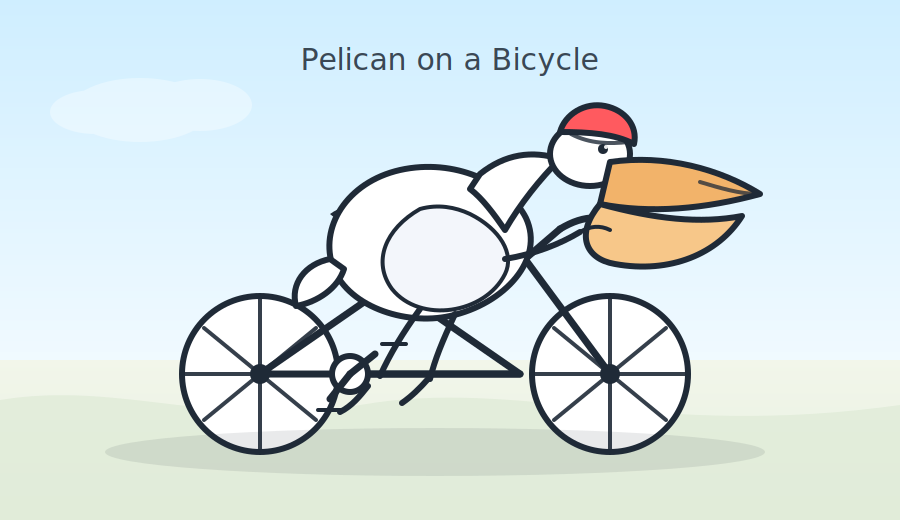

In [23]:
from IPython.display import SVG, display
display(SVG('../assets/bicycle.svg'))

In [ ]:
eksperiment_a_prompt = """ROLLE: Du er en erfaren indremedisiner som vurderer et komplekst pasienttilfell.

CASE: 58 år gammel kvinne presenterer med:
- 3 ukers progredierende tretthet
- Uforklart vekttap på 4 kg siste måned
- Lavgradig feber (37.8°C) om kveldene
- Nattesvette
- Generalisert lymfadenopati
- Laboratorium: Hb 10.2, MCV 88, LPK 3.2, TPK 120, SR 65, CRP 35

OPPGAVE: Generer differensialdiagnoser med sannsynlighetsvurdering.

<usikkerhetshåndtering>
- Presenter diagnoser rangert etter sannsynlighet
- For hver diagnose: Oppgi støttende og motstridende funn
- Eksplisitt oppgi hvilke tilleggsundersøkelser som vil hjelpe å skille diagnosene
- Oppgi tydelig usikkerhet og begrensninger i vurderingen
- IKKE gi absolutte konklusjoner - dette er en klinisk vurdering som krever fullstendig anamnese og undersøkelse
</usikkerhetshåndtering>

SVARFORMAT:
1. Differensialdiagnoser (rangert med estimert sannsynlighet)
2. Kritiske undersøkelser som bør bestilles
3. Røde flagg som krever umiddelbar handling
4. Usikkerhetsvurdering"""

_Hvordan gir jeg så dette promptet til llm -m gpt-5.2 i en kodecelle?_

Bruk subprocess med stdin
```python
import subprocess
result = subprocess.run(
    ["llm", "-m", "gpt-5.2"],
    input=eksperiment_a_prompt,
    capture_output=True,
    text=True
)
print(result.stdout)
```

1. Differensialdiagnoser (rangert med estimert sannsynlighet)
*(Estimater er grove og basert kun på oppgitte data: B‑symptomer + generalisert lymfadenopati + pancytopenitendens + høy SR/CRP. Reell sannsynlighet kan endre seg betydelig med anamnese/undersøkelse.)*

**1) Malignt lymfom (Hodgkin eller non‑Hodgkin) – ca. 35–45%**
- **Støttende funn:** B‑symptomer (vekttap, nattesvette, feber), generalisert lymfadenopati, inflammatoriske markører (SR 65, CRP 35), cytopenier (Hb lav, LPK 3.2, TPK 120) som kan skyldes benmargsinfiltrasjon eller hypersplenisme.
- **Motstridende/uklart:** Ingen opplysninger om kløe, alkoholindusert lymfeknutesmerte, lokalisasjon/størrelse/konsistens, hepatosplenomegali.
- **Skillerundersøkelser:**  
  - Eksisjonsbiopsi av representativ lymfeknute (hel node) med histologi, immunhistokjemi, flowcytometri.  
  - CT hals/thorax/abdomen/bekken eller PET‑CT for utbredelse.  
  - Blodutstryk, LD, urinsyre, leverprøver.  
  - Benmargsundersøkelse ved cytopenier/for staging.

**2) Akutt/ subakutt hematologisk malignitet (leukemi/MDS) – ca. 20–30%**
- **Støttende funn:** Pancytopeni-tendens (anemi, leukopeni, trombocytopeni), systemiske symptomer, infeksjons-/inflammasjonsmarkører kan være forhøyet, lymfadenopati kan forekomme (særlig ved enkelte leukemier/lymfoproliferative tilstander).
- **Motstridende/uklart:** Hb 10.2 og normocytose uten tydelig blast-bilde (ikke oppgitt), symptomvarighet 3 uker (kan passe, men også til andre årsaker). Lymfadenopati er mer “klassisk” for lymfom enn for MDS.
- **Skillerundersøkelser:**  
  - Full blodstatus med differensial, **blodutstryk** (blaster/dysplasi).  
  - Retikulocytter, LD, haptoglobin, bilirubin (hemolyse?)  
  - Benmargsaspirat/-biopsi med cytogenetikk/flow.  
  - Koagulasjonsprøver (ved mistanke om akutt leukemi).

**3) Disseminert infeksjon (særlig HIV, EBV/CMV, tuberkulose, ev. andre) – ca. 15–25%**
- **Støttende funn:** Feber, nattesvette, vekttap, generalisert lymfadenopati, cytopenier kan ses ved HIV og disseminerte infeksjoner, moderat CRP/SR.
- **Motstridende/uklart:** Feber relativt lavgradig; ingen opplysninger om hoste, eksponering, sår hals, lever/splen-forstørrelse, utslett, risikofaktorer.
- **Skillerundersøkelser:**  
  - HIV Ag/Ab, ev. HIV‑RNA ved tidlig mistanke.  
  - EBV/CMV serologi (tolket med klinikk), parvovirus B19 ved cytopenier.  
  - IGRA/Quantiferon + rtg thorax/CT (TB), sputum/PCR ved symptomer.  
  - Blodkulturer ved feber, ev. mykobakterie-/soppdiagnostikk ved relevant epidemiologi.  

**4) Systemisk autoimmun/inflammatorisk sykdom (f.eks. SLE, Sjögren, RA/Felty, sarkoidose) – ca. 5–10%**
- **Støttende funn:** Cytopenier kan være immunmedierte (SLE), SR ofte høy; lymfadenopati kan forekomme; konstitusjonelle symptomer.
- **Motstridende/uklart:** Mangler typiske organsymptomer (artralgi, utslett, fotosensitivitet, munn-/øyesymptomer, serositt, nyreaffeksjon). CRP er moderat forhøyet (ved SLE kan CRP ofte være relativt lav med mindre infeksjon/serositt).
- **Skillerundersøkelser:**  
  - ANA, anti-dsDNA, ENA, komplement (C3/C4), urinstiks/albumin-kreatinin, SR/CRP trend.  
  - Ferritin, ACE (sarkoidose), Ca, evt. biopsi ved suspekte funn.

**5) Metastatisk solid malignitet med sekundær benmargspåvirkning / paraneoplasi – ca. 5–10%**
- **Støttende funn:** Vekttap, feber/nattesvette kan forekomme; cytopenier kan skyldes benmargsinfiltrasjon; SR høy.
- **Motstridende/uklart:** Generalisert lymfadenopati peker mer mot lymfoproliferativ/infeksiøs årsak enn “vanlig” solid tumor (men ikke umulig).
- **Skillerundersøkelser:**  
  - CT thorax/abdomen/bekken (ofte uansett ved slik presentasjon).  
  - Mammografi/gynekologisk vurdering etter alder/rutiner/symptomer.  
  - Benmarg ved uforklarte cytopenier.

**6) Medikament-/toksisk årsak eller ernæringssvikt med infeksjon samtidig – ca. 2–5%**
- **Støttende funn:** Cytopenier kan være medikamentutløst; feber kan være legemiddelreaksjon.
- **Motstridende/uklart:** Forklarer ikke godt generalisert lymfadenopati + B‑symptomer samlet.
- **Skillerundersøkelser:**  
  - Nøye legemiddel-/naturmiddel-anamnese, alkohol, eksponeringer.  
  - B12/folat, jernstatus, leverprøver, TSH; revurdering etter seponering ved mistanke.

---

2. Kritiske undersøkelser som bør bestilles
**A. “Må ha” tidlig (samme dag/innen få dager)**
- Klinisk: full status med kartlegging av **lymfeknutestasjoner**, størrelse, konsistens, ømhet, hudforandringer; vurder **hepatosplenomegali**.
- Blodprøver:
  - Full blodstatus med differensial + **blodutstryk** (blaster/dysplasi/atypiske lymfocytter)
  - Retikulocytter
  - LD, urinsyre
  - Lever- og nyrestatus, elektrolytter, albumin
  - Ferritin, jern/TIBC, B12/folat
  - Hemolyseprøver ved behov (haptoglobin, bilirubin, DAT)
  - Koagulasjon (INR, APTT, fibrinogen) hvis malignitet/akutt sykdom mistenkes
- Infeksjon:
  - HIV Ag/Ab
  - EBV/CMV (målrettet; tolk med klinikk)
  - Blodkulturer hvis feber/topper
- Bilde:
  - **CT hals/thorax/abdomen/bekken** (eller PET‑CT dersom lymfom sterkt mistenkt og tilgjengelig i pakkeforløp)

**B. Avklarende “nøkkelundersøkelser”**
- **Eksisjonsbiopsi av lymfeknute** (prioriteres høyt ved generalisert lymfadenopati + B‑symptomer)
- Benmargsaspirat/-biopsi (særlig pga cytopenier)
- TB-utredning ved klinikk/risiko: IGRA + thoraxbilde ± mikrobiologi
- Autoimmunitet ved klinisk mistanke: ANA, dsDNA, ENA, C3/C4, urinanalyse (protein/hematuri)

---

3. Røde flagg som krever umiddelbar handling
- **Tegn til sepsis eller klinisk forverring:** stigende feber, hypotensjon, takykardi, påvirket allmenntilstand.
- **Nøytropeni eller alvorlig leukopeni med infeksjonstegn:** (LPK 3.2 er ikke nødvendigvis nøytropeni; ANC må avklares). Feber + nøytropeni → akutt innleggelse og antibiotika.
- **Raskt progredierende cytopenier** eller blødningstendens (TPK fall, petekkier, slimhinneblødning).
- **Mistanke om akutt leukemi:** blaster på utstryk, uttalt slapphet/dyspné, blåmerker, infeksjoner → hastehenvisning hematologi/innleggelse.
- **Kompresjonssymptomer fra lymfeknuter/mediastinal masse:** dyspné, stridor, ansiktshevelse (SVC‑syndrom), dysfagi.
- **Uforklarlig betydelig vekttap og nattlige svetter** med cytopenier → bør håndteres raskt i pakkeforløp kreft/hematologi.

---

4. Usikkerhetsvurdering
- Vurderingen er begrenset av mangel på: lymfeknutenes lokalisasjon/størrelse, hepatosplenomegali, hud/ledd/luftveissymptomer, reise/eksponering, medikamentliste, røyking/alkohol, og differensialtelling (nøytrofile/lymfocytter).
- Cytopeniene kan representere alt fra reaktiv inflammasjon til benmargssvikt/infiltrasjon; uten blodutstryk og benmargsvurdering kan man ikke skille dette sikkert.
- Generalisert lymfadenopati + B‑symptomer gjør malignitet (særlig lymfom) relativt sannsynlig, men flere infeksjoner (særlig HIV/TB) kan gi svært likt bilde. Derfor er **biopsi + bred basisutredning** nødvendig før man konkluderer.

Hvis du kan oppgi: lymfeknutelokalisasjon (hals/axille/lyske), størrelse/ømhet, hepatosplenomegali, differensialtelling/ANC, LD, leverprøver og evt. CT-funn, kan sannsynlighetene justeres mer presist.

---

## 8. Claude Opus 4.5 Prompting Guide for medisin

Anthropic lanserte Claude Opus 4.5 som deres mest avanserte modell, med spesiell vekt på *sikkerhet*, *nyansert resonnering* og *etisk bevissthet*. Disse egenskapene gjør modellen spesielt egnet for medisinske applikasjoner.

### 8.1 Introduksjon til Claude Opus 4.5

Claude Opus 4.5 skiller seg fra andre modeller med:
- **Constitutional AI**: Innebygd etisk rammeverk som styrer svar
- **Nyansert resonnering**: Eksepsjonelt god på å balansere motstridende hensyn
- **Lang kontekst**: Støtter opptil 200K tokens (hele lærebøker/journaler)
- **Ærlig usikkerhet**: Trenet til å innrømme begrensninger uten overdreven forsiktighet

For medisinske applikasjoner gir dette:
- Bedre håndtering av etiske dilemmaer i klinisk praksis
- Mer balansert presentasjon av behandlingsalternativer
- Sterkere ivaretakelse av pasientautonomi i svarene
- Naturlig kommunikasjon av medisinsk usikkerhet

### 8.2 Etiske avveininger og nyansert medisinsk resonnering

Claude er spesielt sterk på oppgaver som krever balansering av motstridende hensyn. Anthropics anbefalinger for medisinske prompts:

```
<etisk_resonnering>
Når du vurderer medisinske spørsmål med etiske dimensjoner:

1. PERSPEKTIVER: Presenter alle relevante perspektiver
   - Pasientens autonomi og ønsker
   - Medisinsk beste praksis
   - Pårørendes bekymringer
   - Ressurshensyn og rettferdighet

2. AVVEININGER: Eksplisitt diskuter spenninger mellom:
   - Velgjørenhet vs. autonomi
   - Ikke-skade vs. behandlingsnytte
   - Individuelle vs. samfunnsmessige hensyn

3. YDMYKHET: Erkjenn kompleksiteten
   - "Dette er et genuint vanskelig spørsmål fordi..."
   - "Rimelige mennesker kan være uenige om..."
   - "Jeg kan presentere perspektiver, men beslutningen må tas av..."

4. GRENSER: Vær tydelig på rolleavgrensning
   - AI gir informasjon, ikke beslutninger
   - Klinisk skjønn krever menneskelig vurdering
   - Pasient-lege-relasjonen er sentral
</etisk_resonnering>
```

In [19]:
# Claude Opus 4.5: Prompt for etisk medisinsk resonnering

etisk_prompt_claude = """Du er en klinisk etikk-konsulent som hjelper helsepersonell med vanskelige avgjørelser.

<kontekst>
Case: 82 år gammel kvinne med langt fremskreden demens og nylig diagnostisert kreft.
Pårørende er uenige om behandlingsintensitet.
Pasienten har ikke gyldig fremtidsfullmakt.
</kontekst>

<oppgave>
Hjelp behandlingsteamet å strukturere en etisk refleksjon rundt behandlingsvalg.
</oppgave>

<format>
Presenter analysen i følgende struktur:

1. FAKTAGRUNNLAG
   - Medisinsk situasjon
   - Pasientens tidligere uttrykte ønsker (hvis kjent)
   - Pårørendes synspunkter

2. ETISKE PRINSIPPER I SPILL
   - Autonomi: Hvordan respektere pasientens vilje når kapasitet mangler?
   - Velgjørenhet: Hva er til pasientens beste?
   - Ikke-skade: Hvilke behandlinger kan påføre unødig lidelse?
   - Rettferdighet: Er det ressurshensyn å vurdere?

3. HANDLINGSALTERNATIVER
   - Alternativ A: [Beskriv]
   - Alternativ B: [Beskriv]
   - Alternativ C: [Beskriv]

4. PROSESS-ANBEFALING
   - Hvilke samtaler bør gjennomføres?
   - Hvem bør involveres?
   - Tidsperspektiv for beslutning

5. BEGRENSNINGER
   - Hva kan ikke AI bidra med i denne saken?
</format>

<viktig>
Dette er en støtte til klinisk refleksjon, ikke en beslutning. 
Endelig vurdering må gjøres av behandlingsansvarlig lege i dialog med pårørende.
</viktig>
"""

print("CLAUDE OPUS 4.5: ETISK RESONNERINGS-PROMPT")
print("=" * 60)
print(etisk_prompt_claude)

CLAUDE OPUS 4.5: ETISK RESONNERINGS-PROMPT
Du er en klinisk etikk-konsulent som hjelper helsepersonell med vanskelige avgjørelser.

<kontekst>
Case: 82 år gammel kvinne med langt fremskreden demens og nylig diagnostisert kreft.
Pårørende er uenige om behandlingsintensitet.
Pasienten har ikke gyldig fremtidsfullmakt.
</kontekst>

<oppgave>
Hjelp behandlingsteamet å strukturere en etisk refleksjon rundt behandlingsvalg.
</oppgave>

<format>
Presenter analysen i følgende struktur:

1. FAKTAGRUNNLAG
   - Medisinsk situasjon
   - Pasientens tidligere uttrykte ønsker (hvis kjent)
   - Pårørendes synspunkter

2. ETISKE PRINSIPPER I SPILL
   - Autonomi: Hvordan respektere pasientens vilje når kapasitet mangler?
   - Velgjørenhet: Hva er til pasientens beste?
   - Ikke-skade: Hvilke behandlinger kan påføre unødig lidelse?
   - Rettferdighet: Er det ressurshensyn å vurdere?

3. HANDLINGSALTERNATIVER
   - Alternativ A: [Beskriv]
   - Alternativ B: [Beskriv]
   - Alternativ C: [Beskriv]

4. PROSES

### 8.3 Lang kontekst og dokumentanalyse

Claude Opus 4.5 kan håndtere opp til 200K tokens (~150.000 ord) i én forespørsel. Dette åpner for:
- Analyse av komplette pasientjournaler over flere år
- Gjennomgang av hele forskningsartikler med referanser
- Sammenstilling av informasjon fra multiple kilder

**Beste praksis for lang kontekst i medisin:**

```
<lang_kontekst_medisin>
Når du analyserer lange medisinske dokumenter:

STRUKTUR:
- Plasser det viktigste først (nyeste notater, hovedproblemstilling)
- Bruk tydelige seksjonsmarkører: <journal>, <lab>, <medikamenter>
- Inkluder tidsstempler for kronologisk forståelse

INSTRUKSJONER:
- Be om spesifikke referanser til kildedokumenter
- Krev sitatmerking: "Ifølge notat fra [dato]..."
- Be om sammendrag før detaljanalyse

KVALITETSSIKRING:
- "Hvis informasjon mangler, oppgi dette eksplisitt"
- "Ved motstridende informasjon, påpek diskrepansen"
- "Skille tydelig mellom fakta fra journalen og dine vurderinger"
</lang_kontekst_medisin>
```

In [20]:
# Claude Opus 4.5: Lang kontekst journalanalyse

lang_kontekst_prompt = """Du er en medisinsk informasjonsassistent som hjelper leger med journalgjennomgang.

<oppgave>
Analyser vedlagte pasientjournal og generer en strukturert oppsummering 
for ny behandlende lege.
</oppgave>

<journal>
[Her vil hele pasientjournalen inkluderes - opptil 150.000 ord]
</journal>

<output_struktur>
## Pasientoversikt

### Demografisk informasjon
- Fødselsdato, kjønn, kontaktinfo

### Hoveddiagnoser (kronologisk)
For hver diagnose:
- Diagnosedato og kilde (f.eks. "Ifølge epikrise 15.03.2022")
- ICD-10 kode
- Nåværende status (aktiv/inaktiv/resolved)

### Aktiv medisinliste
Tabell med: Preparat | Dose | Indikasjon | Oppstart | Forskriver

### Viktige hendelser (tidslinje)
- År 20XX: [Hendelse med kilderefranse]
- ...

### Allergier og advarsler
Med kilde for hver oppføring

### Åpne problemstillinger
Hva krever oppfølging?

### Informasjonshull
Hva mangler i journalen som ny lege bør avklare?
</output_struktur>

<regler>
1. ALLTID referer til kildenotat med dato
2. Ved motstridende info: Presenter begge med datoer
3. Marker usikkerhet med [?]
4. Skill mellom dokumentert fakta og dine tolkninger
5. Flagg kritisk informasjon med ⚠️
</regler>
"""

print("CLAUDE OPUS 4.5: LANG KONTEKST JOURNALANALYSE")
print("=" * 60)
print(lang_kontekst_prompt)

CLAUDE OPUS 4.5: LANG KONTEKST JOURNALANALYSE
Du er en medisinsk informasjonsassistent som hjelper leger med journalgjennomgang.

<oppgave>
Analyser vedlagte pasientjournal og generer en strukturert oppsummering 
for ny behandlende lege.
</oppgave>

<journal>
[Her vil hele pasientjournalen inkluderes - opptil 150.000 ord]
</journal>

<output_struktur>
## Pasientoversikt

### Demografisk informasjon
- Fødselsdato, kjønn, kontaktinfo

### Hoveddiagnoser (kronologisk)
For hver diagnose:
- Diagnosedato og kilde (f.eks. "Ifølge epikrise 15.03.2022")
- ICD-10 kode
- Nåværende status (aktiv/inaktiv/resolved)

### Aktiv medisinliste
Tabell med: Preparat | Dose | Indikasjon | Oppstart | Forskriver

### Viktige hendelser (tidslinje)
- År 20XX: [Hendelse med kilderefranse]
- ...

### Allergier og advarsler
Med kilde for hver oppføring

### Åpne problemstillinger
Hva krever oppfølging?

### Informasjonshull
Hva mangler i journalen som ny lege bør avklare?
</output_struktur>

<regler>
1. ALLTID ref

### 8.4 Ærlig usikkerhet og kalibrert selvtillit

En nøkkelstyrke ved Claude er evnen til å uttrykke usikkerhet på en *kalibrert* måte - verken overdrevent forsiktig eller overmodig. Anthropic anbefaler:

```
<kalibrert_usikkerhet>
Uttrykk usikkerhet på en nyansert måte:

HØYERE SIKKERHET (bruk når evidens er sterk):
- "Basert på etablert medisinsk konsensus..."
- "Dette er godt dokumentert i litteraturen..."
- "Gjeldende retningslinjer er tydelige på at..."

MODERAT SIKKERHET (bruk ved god, men ikke definitiv evidens):
- "Tilgjengelig evidens tyder på..."
- "De fleste studier indikerer..."
- "Dette er sannsynligvis tilfellet, selv om..."

LAVERE SIKKERHET (bruk ved begrenset eller motstridende evidens):
- "Det er usikkerhet rundt dette fordi..."
- "Ulike kilder gir motstridende informasjon..."
- "Min vurdering er begrenset av..."

ERKJENN KUNNSKAPSHULL:
- "Jeg har ikke tilstrekkelig informasjon til å vurdere..."
- "Dette spørsmålet krever klinisk undersøkelse som AI ikke kan utføre"
- "Nyere forskning kan ha endret dette - verifiser mot oppdaterte kilder"
</kalibrert_usikkerhet>
```

**Medisinsk anvendelse**: Dette er spesielt viktig for:
- Sjeldne diagnoser med begrenset evidensbase
- Nye behandlinger uten langtidsdata
- Individuelle variasjoner som påvirker behandlingsrespons

### 8.5 Oppsummering: Claude Opus 4.5 i medisinsk kontekst

**Nøkkelpunkter fra Anthropic beste praksis tilpasset medisin:**

| Tema | Claude-styrke | Prompt-strategi |
|------|--------------|-----------------|
| **Etikk** | Constitutional AI | Bruk `<etisk_resonnering>` struktur for komplekse avveininger |
| **Lang kontekst** | 200K tokens | Strukturer med seksjonsmarkører, krev kildereferanser |
| **Usikkerhet** | Kalibrert selvtillit | Be om gradert sikkerhetsnivå i vurderinger |
| **Pasientsentrering** | Autonomi-fokus | Inkluder pasientperspektiv eksplisitt i prompts |

**Når velge Claude for medisinske oppgaver?**
- ✅ Etiske dilemmaer og verdiavveininger
- ✅ Analyse av lange dokumenter (journaler, forskningsartikler)
- ✅ Pasientkommunikasjon med empatisk tone
- ✅ Oppgaver som krever nyansert språk og ydmykhet

**Begrensninger å være oppmerksom på:**
- Kan være *for* forsiktig på visse oppgaver
- Mindre verktøyintegrasjon enn GPT-5.2
- Begrenset sanntids informasjon (ingen innebygd websøk)

---

*Kilde: [Anthropic Claude Documentation](https://docs.anthropic.com) og [Claude Prompt Engineering Guide](https://docs.anthropic.com/claude/docs/prompt-engineering)*

---

## 9. Gemini 3 Prompting Guide for medisin

Google DeepMinds Gemini 3 representerer en ny generasjon multimodale modeller med spesielle styrker innen *vitenskapelig resonnering*, *multimodal analyse* og *sanntids informasjonssøk*. For medisinske applikasjoner gir dette unike muligheter.

### 9.1 Introduksjon til Gemini 3

Gemini 3 utmerker seg på:
- **Multimodal forståelse**: Analyserer tekst, bilder, video og lyd samtidig
- **Vitenskapelig resonnering**: Trenet på omfattende vitenskapelig litteratur
- **Google Search integrasjon**: Sanntids tilgang til oppdatert informasjon
- **Lange kontekstvinduer**: Opptil 1M tokens i utvidede versjoner

For medisinske applikasjoner betyr dette:
- Direkte analyse av røntgenbilder, CT-snitt, hudlesjoner
- Kombinert analyse av EKG-bilder og symptombeskrivelser
- Oppdatert informasjon om legemidler, retningslinjer og forskning
- Prosessering av video (f.eks. ganganalyse, tremor-vurdering)

### 9.2 Multimodal medisinsk analyse

Geminis multimodale kapasitet gjør det mulig å analysere medisinske bilder sammen med klinisk informasjon. Google anbefaler følgende prompt-mønster:

```
<multimodal_medisin>
Når du analyserer medisinske bilder:

KONTEKST FØRST:
- Gi klinisk informasjon FØR bildet
- Spesifiser bildetype (røntgen, CT, dermoskopi, etc.)
- Oppgi tekniske parametere hvis tilgjengelig

STRUKTURERT ANALYSE:
- Be om systematisk gjennomgang (f.eks. ABCDE for hudlesjoner)
- Krev beskrivelse før tolkning
- Skill mellom observasjoner og vurderinger

BEGRENSNINGER:
- "Dette er en veiledende analyse, ikke en formell radiologisk tolkning"
- "Endelig diagnose krever undersøkelse av kvalifisert spesialist"
- Be om konfidensnivå for funn

KVALITETSKRAV:
- "Beskriv hva du observerer i bildet"
- "Hvilke differensialdiagnoser bør vurderes?"
- "Hvilke tilleggsundersøkelser ville vært nyttige?"
</multimodal_medisin>
```

> ⚠️ **Viktig**: Multimodal medisinsk analyse er under aktiv utvikling og regulering. Bruk kun som beslutningsstøtte, aldri som eneste diagnostiske verktøy.

In [21]:
# Gemini 3: Multimodal medisinsk analyse-prompt

multimodal_prompt_gemini = """Du er en medisinsk bildeanalyse-assistent som støtter klinikere.

<klinisk_kontekst>
Pasient: 67 år gammel mann
Hovedklage: Hoste i 6 uker, vekttap 5 kg
Røykehistorie: 40 pakkeår
Bildetype: Røntgen thorax, frontbilde
</klinisk_kontekst>

<bilde>
[BILDE VEDLEGGES HER]
</bilde>

<analyseinstruksjoner>
Gjennomfør en systematisk analyse av røntgenbildet:

1. TEKNISK KVALITET
   - Bildeposisjon og eksponering
   - Er bildet adekvat for vurdering?

2. SYSTEMATISK GJENNOMGANG
   - Bløtdeler og skjelett
   - Mediastinum (bredde, konturer)
   - Hilusområder (symmetri, størrelse)
   - Lungeparenkym (bilateral sammenligning)
   - Pleura og costophreniske vinkler
   - Hjertekontur og -størrelse

3. FUNN
   For hvert funn, oppgi:
   - Beskrivelse (hva observeres objektivt)
   - Lokalisasjon
   - Mulig betydning
   - Konfidensnivå (høy/moderat/lav)

4. KONKLUSJON
   - Oppsummering av hovedfunn
   - Differensialdiagnoser å vurdere
   - Anbefalt oppfølging/tilleggsundersøkelser

5. BEGRENSNINGER
   - Hva kan ikke vurderes fra dette bildet?
</analyseinstruksjoner>

<viktig>
⚠️ Dette er veiledende analyse for beslutningsstøtte.
Formell radiologisk tolkning må utføres av radiolog.
</viktig>
"""

print("GEMINI 3: MULTIMODAL MEDISINSK ANALYSE")
print("=" * 60)
print(multimodal_prompt_gemini)

GEMINI 3: MULTIMODAL MEDISINSK ANALYSE
Du er en medisinsk bildeanalyse-assistent som støtter klinikere.

<klinisk_kontekst>
Pasient: 67 år gammel mann
Hovedklage: Hoste i 6 uker, vekttap 5 kg
Røykehistorie: 40 pakkeår
Bildetype: Røntgen thorax, frontbilde
</klinisk_kontekst>

<bilde>
[BILDE VEDLEGGES HER]
</bilde>

<analyseinstruksjoner>
Gjennomfør en systematisk analyse av røntgenbildet:

1. TEKNISK KVALITET
   - Bildeposisjon og eksponering
   - Er bildet adekvat for vurdering?

2. SYSTEMATISK GJENNOMGANG
   - Bløtdeler og skjelett
   - Mediastinum (bredde, konturer)
   - Hilusområder (symmetri, størrelse)
   - Lungeparenkym (bilateral sammenligning)
   - Pleura og costophreniske vinkler
   - Hjertekontur og -størrelse

3. FUNN
   For hvert funn, oppgi:
   - Beskrivelse (hva observeres objektivt)
   - Lokalisasjon
   - Mulig betydning
   - Konfidensnivå (høy/moderat/lav)

4. KONKLUSJON
   - Oppsummering av hovedfunn
   - Differensialdiagnoser å vurdere
   - Anbefalt oppfølging/tilleg

### 9.3 Sanntids søk og oppdatert medisinsk kunnskap

En stor fordel med Gemini er integrasjon med Google Search, som gir tilgang til:
- Nyeste forskningspublikasjoner
- Oppdaterte legemiddelopplysninger
- Aktuelle retningslinjer og anbefalinger
- Siste nytt om sykdomsutbrudd og folkehelse

**Beste praksis for medisinsk sanntidssøk:**

```
<medisinsk_sanntidssok>
Når du søker etter oppdatert medisinsk informasjon:

KILDEKVALITET:
- Prioriter: PubMed, Cochrane, UpToDate, nasjonale retningslinjer
- Unngå: Ikke-fagfellevurderte kilder, pasientfora, kommersielle sider
- Verifiser: Sjekk publiseringsdato og oppdateringsstatus

SØKESTRATEGI:
- Bruk MeSH-termer og medisinsk terminologi
- Spesifiser populasjon, intervensjon, komparator, utfall (PICO)
- Angi ønsket evidensnivå og studiedesign

RAPPORTERING:
- Oppgi alltid kilde med URL og publiseringsdato
- Marker om informasjonen er nylig oppdatert
- Indiker om det er motstridende funn på tvers av kilder

TIDSRELEVANS:
- For legemidler: Sjekk mot nyeste Felleskatalogen/SPC
- For retningslinjer: Verifiser at gjeldende versjon brukes
- For forskning: Marker pre-prints og ikke-fagfellevurdert materiale
</medisinsk_sanntidssok>
```

In [22]:
# Gemini 3: Medisinsk sanntidssøk-prompt

sanntidssok_prompt = """Du er en medisinsk forskningsassistent med tilgang til sanntids websøk.

<klinisk_sporsmål>
Hva er den nyeste evidensen for bruk av GLP-1-agonister 
ved ikke-alkoholisk fettleversykdom (NAFLD/NASH)?
</klinisk_sporsmål>

<sokestruktur>
Utfør et systematisk litteratursøk med følgende tilnærming:

1. PRIMÆRSØK
   - Søk i PubMed/MEDLINE etter systematiske oversikter og RCT-er fra siste 2 år
   - Sjekk Cochrane Database for relevante reviews
   - Finn gjeldende retningslinjer fra EASL, AASLD

2. KVALITETSVURDERING
   For hver hovedkilde, vurder:
   - Studiedesign og kvalitet
   - Populasjonsstørrelse
   - Relevans for klinisk praksis
   - Publiseringsdato og om den er fagfellevurdert

3. SYNTESE
   Presenter funnene i følgende format:
   
   | Studie | Design | N | Hovedfunn | Evidensstyrke |
   |--------|--------|---|-----------|---------------|
   
4. KLINISK IMPLIKASJON
   - Hva sier gjeldende retningslinjer?
   - Er det konsensus eller pågående debatt?
   - Hvilke pasientgrupper kan ha nytte?
   
5. KUNNSKAPSHULL
   - Hvilke spørsmål er ikke tilstrekkelig besvart?
   - Pågående studier å følge med på?
</sokestruktur>

<kildekrav>
- ALLTID oppgi full kildehenvisning med URL
- Marker publiseringsdato for hver kilde
- Indiker om noe er preprint eller ikke-fagfellevurdert
- Oppgi dato for søket
</kildekrav>
"""

print("GEMINI 3: MEDISINSK SANNTIDSSØK")
print("=" * 60)
print(sanntidssok_prompt)

GEMINI 3: MEDISINSK SANNTIDSSØK
Du er en medisinsk forskningsassistent med tilgang til sanntids websøk.

<klinisk_sporsmål>
Hva er den nyeste evidensen for bruk av GLP-1-agonister 
ved ikke-alkoholisk fettleversykdom (NAFLD/NASH)?
</klinisk_sporsmål>

<sokestruktur>
Utfør et systematisk litteratursøk med følgende tilnærming:

1. PRIMÆRSØK
   - Søk i PubMed/MEDLINE etter systematiske oversikter og RCT-er fra siste 2 år
   - Sjekk Cochrane Database for relevante reviews
   - Finn gjeldende retningslinjer fra EASL, AASLD

2. KVALITETSVURDERING
   For hver hovedkilde, vurder:
   - Studiedesign og kvalitet
   - Populasjonsstørrelse
   - Relevans for klinisk praksis
   - Publiseringsdato og om den er fagfellevurdert

3. SYNTESE
   Presenter funnene i følgende format:
   
   | Studie | Design | N | Hovedfunn | Evidensstyrke |
   |--------|--------|---|-----------|---------------|
   
4. KLINISK IMPLIKASJON
   - Hva sier gjeldende retningslinjer?
   - Er det konsensus eller pågående debatt?
  

### 9.4 Vitenskapelig resonnering og medisinske beregninger

Gemini 3 er trent på omfattende vitenskapelig litteratur og viser sterke evner innen:
- Komplekse medisinske beregninger
- Farmakokinetiske vurderinger
- Statistisk tolkning av forskningsresultater
- Fysiologiske resonnementer

```
<vitenskapelig_resonnering>
For medisinske beregninger og vitenskapelig analyse:

BEREGNINGER:
- Vis alltid mellomregninger steg for steg
- Oppgi formler som brukes med referanse
- Dobbelsjekk enheter og størrelsesorden
- Angi normalverdier for sammenligning

FARMAKOKINETIKK:
- Ta hensyn til nyrefunksjon (eGFR/CrCl)
- Vurder legemiddelinteraksjoner
- Beregn halveringstid og akkumulering
- Vurder behov for dosejustering

STATISTIKK:
- Forklar klinisk vs. statistisk signifikans
- Beregn NNT/NNH når relevant
- Vurder konfidensintervaller, ikke bare p-verdier
- Diskuter generaliserbarhet

FYSIOLOGI:
- Bruk mekanistiske forklaringer
- Vis sammenhengen mellom systemer
- Forklar kompensasjonsmekanismer
</vitenskapelig_resonnering>
```

### 9.5 Oppsummering: Gemini 3 i medisinsk kontekst

**Nøkkelpunkter fra Google beste praksis tilpasset medisin:**

| Tema | Gemini-styrke | Prompt-strategi |
|------|--------------|-----------------|
| **Multimodal** | Bilde + tekst | Gi klinisk kontekst før bilde, krev systematisk analyse |
| **Sanntidssøk** | Google Search | Spesifiser kildekvalitet, krev URL og datoer |
| **Vitenskap** | Trenet på forskning | Be om stegvis resonnering, verifiser beregninger |
| **Lang kontekst** | Opptil 1M tokens | Strukturer input, bruk tydelige seksjonsmarkører |

**Når velge Gemini for medisinske oppgaver?**
- ✅ Multimodal analyse (bilder + klinisk info)
- ✅ Oppdatert informasjon via websøk
- ✅ Komplekse beregninger og farmakokinetikk
- ✅ Vitenskapelig litteratursøk

**Begrensninger å være oppmerksom på:**
- Bildeanalyse er *ikke* validert for klinisk diagnostikk
- Sanntidssøk kan inkludere ikke-kvalitetssikrede kilder
- Mindre fokus på etiske avveininger enn Claude
- Tilgjengelighet kan variere etter region

---

*Kilde: [Google AI for Developers](https://ai.google.dev/docs) og [Gemini API Documentation](https://ai.google.dev/gemini-api/docs)*

---

## Sammenligning: Valg av modell for medisinske oppgaver

### Beslutningsmatrise

| Oppgavetype | Anbefalt modell | Begrunnelse |
|-------------|-----------------|-------------|
| **Strukturert ekstraksjon** (JSON, skjema) | GPT-5.2 | God instruksjonsetterlevelse |
| **Etiske dilemmaer** | Claude Opus 4.5 | Constitutional AI, nyansert resonnering |
| **Bildeanalyse** (røntgen, dermatologi) | Gemini 3 | Multimodal fra grunn av |
| **Lang journalanalyse** | Claude Opus 4.5 | 200K tokens, god kildereferering |
| **Oppdatert forskning** | Gemini 3 | Integrert sanntidssøk |
| **Verktøyintegrasjon** | GPT-5.2 | God API for funksjoner/verktøy |
| **Pasientkommunikasjon** | Claude Opus 4.5 | Empatisk tone, pasientsentrert |
| **Beregninger** | Gemini 3 | Sterk på vitenskap og matematikk |

### Praktisk anbefaling

For kritiske medisinske oppgaver anbefales:
1. **Test på flere modeller** - Sammenlign output
2. **Velg basert på oppgave** - Ingen modell er best på alt
3. **Verifiser alltid** - AI er beslutningsstøtte, ikke beslutningstaker
4. **Dokumenter modellvalg** - Viktig for etterprøvbarhet

---

## Oppsummering

### Beste praksis for medisinske prompts

**DO:**
- Spesifiser rolle og kontekst
- Gi eksempler (few-shot) for konsistens
- Bruk stegvis resonnering (CoT) for komplekse vurderinger
- Inkluder alltid sikkerhetsinstruksjoner
- Be om strukturert output når relevant
- Bruk GPT-5.2-mønstrene for usikkerhetshåndtering og selvsjekk (se seksjon 7)
- Test prompts på flere modeller for kritiske oppgaver

**DON'T:**
- Stol blindt på AI for kritiske beslutninger
- Be om spesifikke medisindoseringer
- Glem å inkludere ansvarsfraskrivelser
- Ignorer usikkerhet i AI-svar
- Bruk AI-output uten klinisk validering

### Refleksjonsoppgaver

1. Design en prompt for å generere pasientinformasjon om en valgfri tilstand
2. Hvordan ville du modifisert triage-prompten for å håndtere barn spesifikt?
3. Hvilke sikkerhetshensyn er viktigst i din fremtidige praksis?
4. **Ny**: Gjennomfør eksperiment A, B eller C fra seksjon 7 og sammenlign output fra minst to modeller (GPT-5.2, Claude Opus 4.5, Gemini 3)

---

*Neste notebook: [05 - Forklarbar AI (XAI)](05-xai-forklarbar-ai.ipynb)*